In [1]:
from brian2 import *
import numpy as np

In [2]:
N = 1
v_r = -70*mV # reset voltage
v_th = -55*mV  # threshold voltage
E_l = -90*mV
dia = 20*um
length = 20*um
SA = (2*pi*(dia/2)*length) # units are um2
gL = 1*psiemens/um2 * SA # units are psiemens
g_II = 40*psiemens/um2 * SA # units are psiemens...becomes 50 psiemens
g_EE = 40*psiemens/um2 * SA # units are psiemens...becomes 50 psiemens
we = 5*nS  # excitatory synaptic weight
wi = 15*nS # inhibitory synaptic weight
# g_EI = 24*psiemens/um2 * SA # units are psiemens
# g_IE = 8*psiemens/um2 * SA # units are psiemens
C_mem = 10e-6*farad/cm2 * SA # units are farad
E_ex = 0*mV
E_i = -80*mV 
v_c = 0*mV
I_c = 1000*pamp # same as I_ext, units pamp
tau_ge = 20*ms
tau_gi_c = 6.8*ms # units of ms
integ_method = 'heun'
run_time = 100*ms

model_0 = '''
dv/dt = (1/C_mem)*(ge*(v - E_ex) + gi*(v - E_i) + gL*(v - E_l) + I) : volt (unless refractory)
dge/dt = -ge/tau_ge : siemens
dgi/dt = -gi/tau_gi : siemens
I : ampere
tau_gi : second
'''

model_1 = '''
dv/dt = (1/C_mem)*(gL*(v - E_l) + I) : volt (unless refractory)
dge/dt = -ge/tau_ge : siemens
I : ampere
'''

model_2 = '''
dv/dt = (1/C_mem)*(ge*(v - E_ex) + gL*(v - E_l) + I) : volt (unless refractory)
ge: siemens
I : ampere
'''

In [3]:
# implementing conductance in the synapse equations
# https://brian2.readthedocs.io/en/stable/user/synapses.html?highlight=synapses#summed-variables
start_scope()
G3 = NeuronGroup(N, model_0, threshold='v>v_th', reset='v=v_r', refractory=10*ms, method=integ_method)
G3.I = np.random.normal(I_c,1,1)*1000*pamp
G3.ge = g_EE
G3.gi = g_II
G3.tau_gi = np.random.normal(tau_gi_c, 1,1)*ms
G3.v = v_c
statemon3 = StateMonitor(G3, variables='v',record=0)
spikemon3 = SpikeMonitor(G3,variables='v')

G4 = NeuronGroup(N, model_0, threshold='v>v_th', reset='v=v_r', refractory=10*ms, method=integ_method)
G4.I = np.random.normal(I_c,1,1)*pamp
G4.ge = g_EE
G4.gi = g_II
G4.tau_gi = np.random.normal(tau_gi_c, 1,1)/2*ms
G4.v = v_c
statemon4 = StateMonitor(G4, variables=['v','ge','gi'],record=0)
spikemon4 = SpikeMonitor(G4,variables='v')

S3 = Synapses(G3, G4, model ='''w : volt''', on_pre='''v_post += w
              ge+=we
              gi+=wi''')
S3.connect(i=0, j=0)
# positive weight for an excitatory connection, -ve weight for inhibitory
S3.w = 0.5*volt

run(run_time)

WARNING    neurongroup_1's variable 'gi' has NaN, very large values, or encountered an error in numerical integration. This is usually a sign that an unstable or invalid integration method was chosen. [brian2.groups.group.invalid_values]


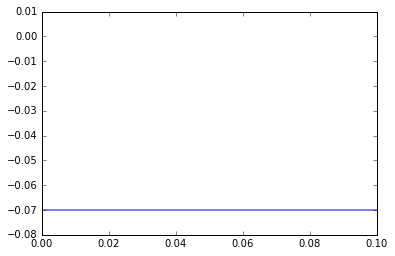

In [4]:
plot(statemon3.t,np.transpose(statemon3.v))

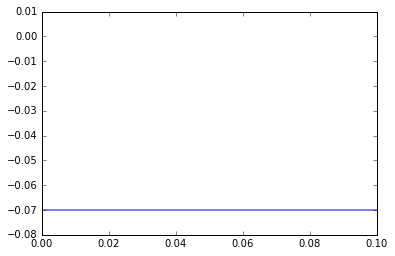

In [5]:
plot(statemon4.t,np.transpose(statemon4.v))

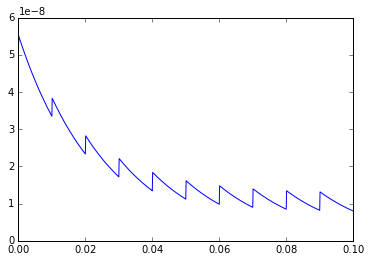

In [6]:
plot(statemon4.t,np.transpose(statemon4.ge))

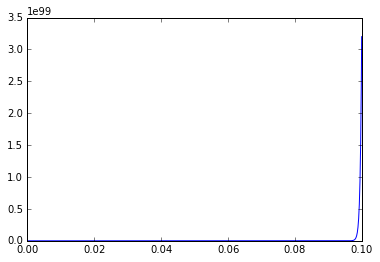

In [7]:
plot(statemon4.t,np.transpose(statemon4.gi))

In [8]:
scheduling_summary()

object,part of,Clock dt,when,order,active
statemonitor (StateMonitor),statemonitor (StateMonitor),100. us (every step),start,0,yes
statemonitor_1 (StateMonitor),statemonitor_1 (StateMonitor),100. us (every step),start,0,yes
neurongroup_1_stateupdater (StateUpdater),neurongroup_1 (NeuronGroup),100. us (every step),groups,0,yes
neurongroup_stateupdater (StateUpdater),neurongroup (NeuronGroup),100. us (every step),groups,0,yes
neurongroup_1_thresholder (Thresholder),neurongroup_1 (NeuronGroup),100. us (every step),thresholds,0,yes
neurongroup_thresholder (Thresholder),neurongroup (NeuronGroup),100. us (every step),thresholds,0,yes
spikemonitor (SpikeMonitor),spikemonitor (SpikeMonitor),100. us (every step),thresholds,1,yes
spikemonitor_1 (SpikeMonitor),spikemonitor_1 (SpikeMonitor),100. us (every step),thresholds,1,yes
synapses_pre (SynapticPathway),synapses (Synapses),100. us (every step),synapses,-1,yes
neurongroup_1_resetter (Resetter),neurongroup_1 (NeuronGroup),100. us (every step),resets,0,yes


In [9]:
spikemon3.spike_trains()

{0: array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90.]) * msecond}

In [10]:
spikemon4.spike_trains()

{0: array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90.]) * msecond}